In [15]:
from pathlib import Path
import pandas as pd

import glob
import numpy as np
import matplotlib.pyplot as plt
from music21 import converter, instrument, note, chord, stream
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.utils import to_categorical


from music21 import converter, instrument, note, chord

In [3]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras import backend as K

import os
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
import tensorflow as tf

In [4]:
songs = []
folder = Path('data/')
for file in folder.rglob('*.mid'):
  songs.append(file)

print(f'Num songs in dataset: {len(songs)}')


Num songs in dataset: 93


In [5]:
# Converting list of paths to our MIDI songs to a sequence of notes/chords 

notes = []
for i,file in enumerate(songs):
    # print(f'{i+1}: {file}')
    try:
      midi = converter.parse(file)
      notes_to_parse = None
      parts = instrument.partitionByInstrument(midi)
      if parts: # file has instrument parts
          notes_to_parse = parts.parts[0].recurse()
      else: # file has notes in a flat structure
          notes_to_parse = midi.flat.notes
      for element in notes_to_parse:
          if isinstance(element, note.Note):
              notes.append(str(element.pitch))
          elif isinstance(element, chord.Chord):
              notes.append('.'.join(str(n) for n in element.normalOrder))
    except:
      print(f'FAILED: {i+1}: {file}')

notes[:10]

['0.3.7', '2.5.9', '2.5.9', '0.3', 'G4', 'D3', 'D4', 'F4', 'A4', 'D3']

In [7]:
sequence_length = 100

# Create a mapping from note to integer
pitchnames = sorted(set(notes))
note_to_int = {note: number for number, note in enumerate(pitchnames)}
numPitches = len(pitchnames)

network_input = []
network_output = []

for i in range(len(notes) - sequence_length):
    seq_in = notes[i:i + sequence_length]
    seq_out = notes[i + sequence_length]
    network_input.append([note_to_int[n] for n in seq_in])
    network_output.append(note_to_int[seq_out])


In [8]:
networkInputShaped = np.reshape(network_input, (len(network_input), sequence_length, 1))
networkInputShaped = networkInputShaped / float(numPitches)

networkOutputEncoded = to_categorical(network_output, num_classes=numPitches)

In [9]:
model = Sequential()
model.add(Dropout(0.2))
model.add(LSTM(256, input_shape=(networkInputShaped.shape[1], networkInputShaped.shape[2]), return_sequences=True))
model.add(Dense(128))
model.add(LSTM(256))
model.add(Dense(numPitches))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

2025-06-03 08:38:51.780207: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:236] Using CUDA malloc Async allocator for GPU: 0
2025-06-03 08:38:51.781613: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 105 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1


In [16]:
history = model.fit(networkInputShaped, networkOutputEncoded, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

Epoch 1/50
91/91 [==============================] - 4s 45ms/step - loss: 4.8895 - accuracy: 0.0361 - val_loss: 5.0035 - val_accuracy: 0.0139
Epoch 2/50
91/91 [==============================] - 2s 22ms/step - loss: 4.8631 - accuracy: 0.0298 - val_loss: 5.1184 - val_accuracy: 0.0139
Epoch 3/50
91/91 [==============================] - 2s 23ms/step - loss: 4.8408 - accuracy: 0.0298 - val_loss: 5.1867 - val_accuracy: 0.0222
Epoch 4/50
91/91 [==============================] - 2s 22ms/step - loss: 4.8300 - accuracy: 0.0305 - val_loss: 5.2262 - val_accuracy: 0.0249
Epoch 5/50
91/91 [==============================] - 2s 22ms/step - loss: 4.8251 - accuracy: 0.0257 - val_loss: 5.2604 - val_accuracy: 0.0139
Epoch 6/50
91/91 [==============================] - 2s 23ms/step - loss: 4.8059 - accuracy: 0.0347 - val_loss: 5.2659 - val_accuracy: 0.0194
Epoch 7/50
91/91 [==============================] - 2s 23ms/step - loss: 4.7852 - accuracy: 0.0354 - val_loss: 5.2893 - val_accuracy: 0.0139
Epoch 8/50
91

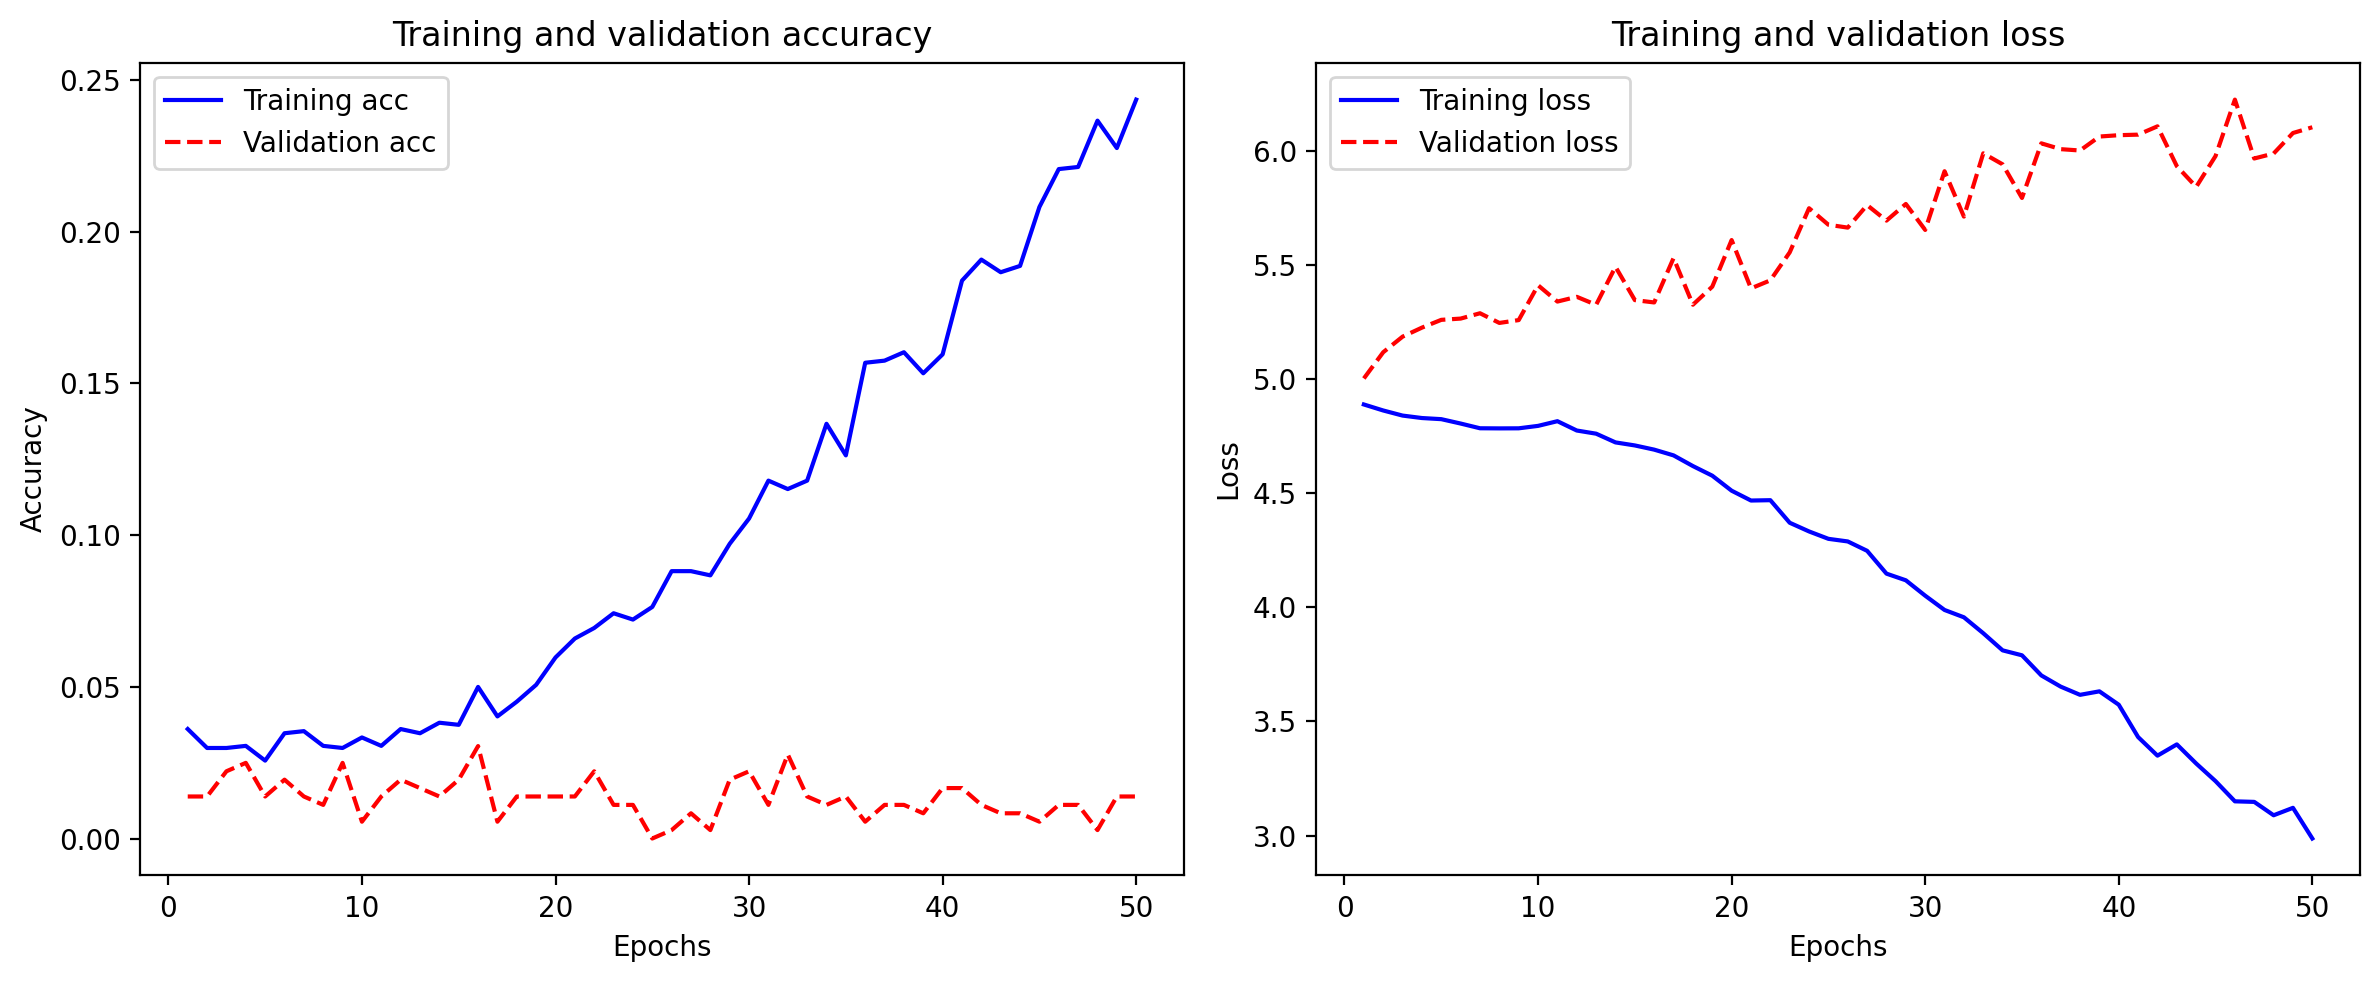

In [17]:
def plot_training_history(history):
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training acc')
    if val_acc:
        plt.plot(epochs, val_acc, 'r--', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r--', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [11]:
def generate_notes(model, network_input, pitchnames, n_vocab, num_generate=500):
    """ Generate notes from the trained model """
    start = np.random.randint(0, len(network_input) - 1)
    print(f"Generating music starting from seed index: {start}")

    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    pattern = network_input[start]
    prediction_output = []

    for _ in range(num_generate):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1)).astype(np.float32)
        prediction_input /= float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)
        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern = np.append(pattern, index)
        pattern = pattern[1:]

    return prediction_output


In [12]:
def create_midi(prediction_output, output_path='output.mid'):
    offset = 0
    output_notes = []

    for pattern in prediction_output:
        # Chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # Single note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=output_path)
    print(f"MIDI file written to: {output_path}")


In [18]:
prediction_output = generate_notes(model, networkInputShaped, pitchnames, numPitches)
create_midi(prediction_output, 'ep_50.mid')

Generating music starting from seed index: 1452
MIDI file written to: ep_50.mid
